# Replication for results

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Loading the data 

In [2]:
data = pd.read_csv("../data/labeled_dataset.csv")

In [3]:
data

,Unnamed: 0,track_name,track_artist,lyrics,genre,tempo,energy,loudness,label
0,0,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,r&b,118.593,0.378,-5.819,1
1,1,Changes,2Pac,"I see no changes, wake up in the morning and I...",rap,111.115,0.657,-6.722,2
2,2,Laps,Zotiyac,"I'mma make your CXRPSE dance Ugh, hop in that ...",rap,140.132,0.453,-9.965,0
3,3,Hot,Confetti,"(Yeah) I'm the new truth, the crypto Erry'body...",pop,168.015,0.908,-3.883,1
4,4,Love Sosa,Chief Keef,"Fuckers in school telling me, always in the ba...",rap,131.965,0.413,-8.193,0
...,...,...,...,...,...,...,...,...,...
1761,1761,Coastin',Cali Life Style,"Mike G, why don't you drop us somethin' else? ...",latin,169.892,0.473,-11.115,2
1762,1762,I'm A G,Rick Ross,Uh I wear a gun like a girdle Bullet proof car...,rap,103.239,0.685,-6.835,0
1763,1763,Slutty Girls,Mr. Knightowl,I was riding in my rola That's when I spotted ...,latin,114.992,0.555,-6.367,1
1764,1764,"Work REMIX (feat. A$AP Rocky, French Montana, ...",A$AP Ferg,I gotta close the window before I record ‘Caus...,rap,130.009,0.733,-5.077,0


In [4]:
data.describe()

,Unnamed: 0,tempo,energy,loudness,label
count,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000
mean,882.500000,120.354673,0.696657,-6.755136,1.429219
std,509.944605,28.883439,0.175414,2.947139,0.787528
min,0.000000,52.654000,0.056100,-24.328000,0.000000
25%,441.250000,95.922500,0.575000,-8.138500,1.000000
50%,882.500000,119.963000,0.717000,-6.291000,2.000000
75%,1323.750000,139.934000,0.835000,-4.704750,2.000000
max,1765.000000,207.992000,1.000000,-1.304000,2.000000


In [5]:
data.columns

Index(['Unnamed: 0', 'track_name', 'track_artist', 'lyrics', 'genre', 'tempo',
       'energy', 'loudness', 'label'],
      dtype='object')

### Columns key:

track_name = Song Name

track_artist = Song Artist

lyrics = raw lyrics text for the song

genre = Playlist genre

tempo = The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

energy = Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

loudness = The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

label =  0 - hate speech,
         1 - offensive  language,
         2 - neither



<AxesSubplot:>

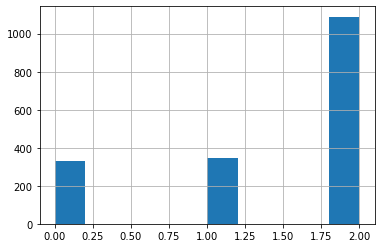

In [6]:
data['label'].hist() #wahre Label aus dem gesamten Set

In [7]:
lyrics = data.lyrics

## Feature generation

In [8]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = []
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) lots of whitespace with one instance

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

def tokenize(lyrics):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", lyrics.lower())).strip()
    #tokens = re.split("[^a-zA-Z]*", lyrics.lower())
    tokens = [stemmer.stem(t) for t in lyrics.split()]
    return tokens

def basic_tokenize(lyrics):
    """Same as tokenize but without the stemming"""
    lyrics = " ".join(re.split("[^a-zA-Z.,!?]*", lyrics.lower())).strip()
    return lyrics.split()

vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords, #We do better when we keep stopwords
    use_idf=True,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.501
    )

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(lyrics).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

C:\Users\Nina\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', "it'", 'onc', 'onli', 'ourselv', "she'", "should'v", 'themselv', 'thi', 'veri', 'wa', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [11]:
#Get POS tags for lyrics and save as a string
lyrics_tags = []
for l in lyrics:
    tokens = basic_tokenize(preprocess(l))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    #for l in range(0, len(tokens)):
    tag_str = " ".join(tag_list)
    lyrics_tags.append(tag_str)
        #print(tokens[l],tag_list[l])

In [12]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None, #We do better when we keep stopwords
    use_idf=False,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.501,
    )

In [13]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(lyrics_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [14]:
#!pip install vaderSentiment
#!pip install textstat

In [15]:
#Now get other features

sentiment_analyzer = VS()

def other_features(lyrics):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    ##SENTIMENT
    sentiment = sentiment_analyzer.polarity_scores(lyrics)
    
    words = preprocess(lyrics) #Get text only
    
    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(lyrics)
    num_terms = len(lyrics.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
               num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']]
    #features = pd.DataFrame(features)
    return features

def get_feature_array(lyrics):
    feats=[]
    for l in lyrics:
        feats.append(other_features(l))
    return np.array(feats)

In [16]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", "vader compound"]

In [17]:
other_features(lyrics[65])

[313.4,
 -709.31,
 900,
 1.1111,
 3671,
 3671,
 810,
 810,
 118,
 0.015,
 0.054,
 0.931,
 0.981]

In [18]:
feats = get_feature_array(lyrics)

In [19]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [20]:
M.shape

(1766, 10543)

In [21]:
#Anmerkung: wir mussten items() statt iteritems() schreiben, weil es das nicht mehr in Python 3 gibt
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

## Running the model 

In [74]:
X = pd.DataFrame(M)
y = data['label'].astype(int)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
#hier wird in Trainings- und Testset aufgeteilt
#wir haben noch shuffle=True eingefügt
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, shuffle=True)

In [25]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [26]:
#Anmerkung: wir haben zusätzlich solver="liblinear" eingefügt, weil sonst L1 nicht unterstützt wird
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01, solver='liblinear'))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [27]:
param_grid = [{}] # Optionally add parameters here

In [28]:
#wir haben noch shuffle=True eingefügt
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42, shuffle=True).split(X_train, y_train), 
                           verbose=2)

In [29]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Nina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   4.2s


C:\Users\Nina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   1.2s


C:\Users\Nina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   1.1s


C:\Users\Nina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   1.2s


C:\Users\Nina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   1.2s


C:\Users\Nina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
y_preds = model.predict(X_test)

In [31]:
y_preds[65] #Label, die das Model für das Testset vorhersagt

0

In [32]:
pd.DataFrame(y_test)

,label
1560,2
212,2
1586,1
836,2
1245,0
...,...
84,2
1598,2
984,2
1179,1


In [33]:
y_train

610     2
1163    0
1096    2
451     0
490     2
       ..
1130    2
1294    0
860     0
1459    0
1126    1
Name: label, Length: 1236, dtype: int32

In [34]:
list(y_train).count(0)

236

In [35]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,10533,10534,10535,10536,10537,10538,10539,10540,10541,10542
1560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.1529,1647.0,1647.0,340.0,340.0,127.0,0.128,0.178,0.694,0.9455
212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.1935,146.0,146.0,31.0,31.0,24.0,0.293,0.175,0.532,-0.7456
1586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.1715,4725.0,4725.0,898.0,898.0,175.0,0.244,0.089,0.667,-0.9997
836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0805,2754.0,2754.0,584.0,584.0,247.0,0.058,0.268,0.674,0.9995
1245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0826,1731.0,1731.0,351.0,351.0,184.0,0.060,0.158,0.782,0.9878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.1359,1800.0,1800.0,368.0,368.0,196.0,0.149,0.135,0.716,-0.9374
1598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.1832,7235.0,7235.0,1392.0,1392.0,150.0,0.153,0.142,0.706,-0.8971
984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.1754,1635.0,1635.0,342.0,342.0,137.0,0.031,0.119,0.850,0.9843
1179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0874,1006.0,1006.0,206.0,206.0,90.0,0.103,0.017,0.880,-0.9600


In [36]:
indices_test = list(X_test.index)

In [37]:
def test_genre():
    test_genre = []
    for num in indices_test:
        test_genre.append(data.genre[num])
    return(test_genre)

In [38]:
pd.DataFrame({'genre': test_genre()})

,genre
0,pop
1,edm
2,rap
3,r&b
4,r&b
...,...
525,rap
526,pop
527,edm
528,r&b


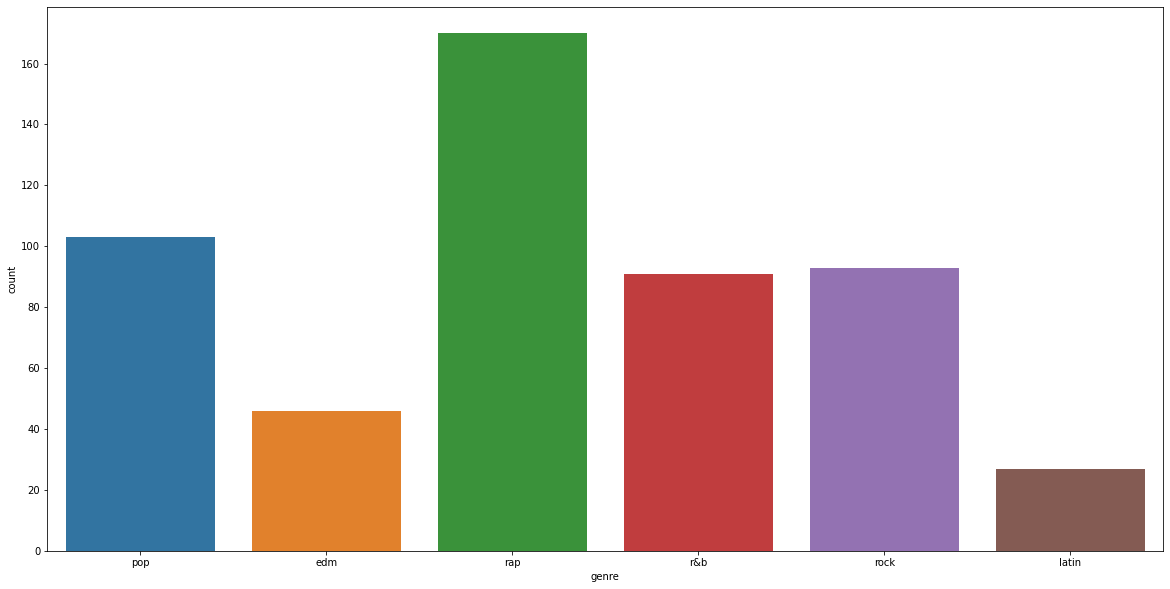

In [39]:
fig,ax = plt.subplots(figsize=(20,10))
ax = seaborn.countplot(x='genre', data=pd.DataFrame({'genre': test_genre()})) #Genres im Testset

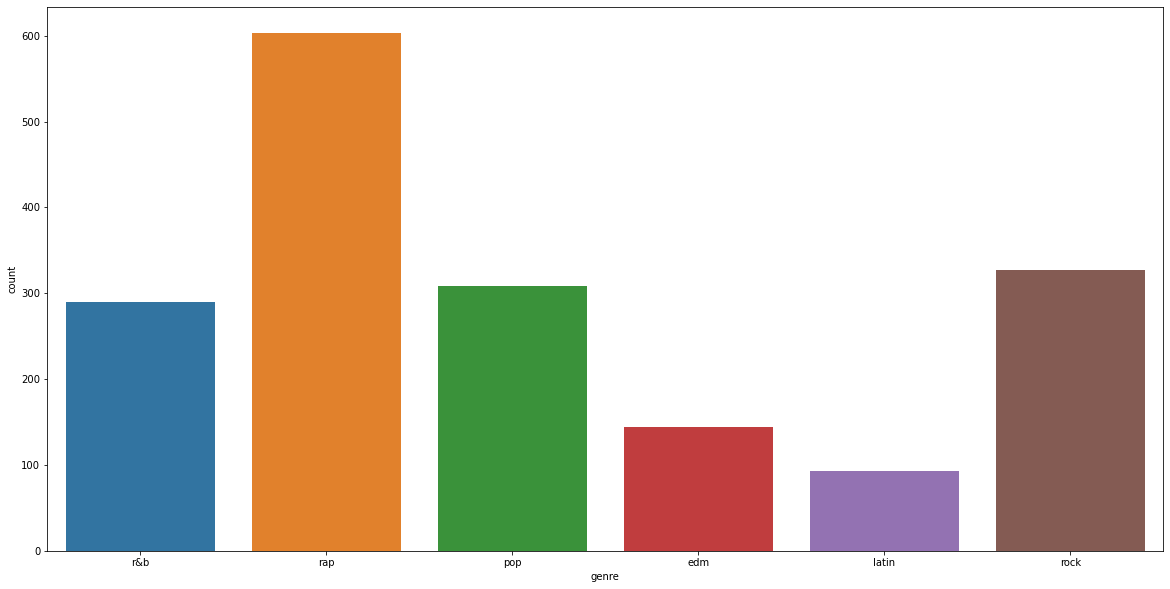

In [40]:
#genres im gesamten Dataset
fig,ax = plt.subplots(figsize=(20,10))
ax = seaborn.countplot(x='genre', data=pd.DataFrame({'genre': data.genre})) #Genres im Dataset

In [41]:
def test_artist():
    test_artist = []
    for num in indices_test:
        test_artist.append(data.track_artist[num])
    return(test_artist)

<AxesSubplot:ylabel='artist'>

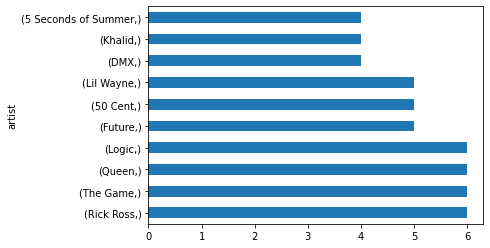

In [42]:
pd.DataFrame({'artist': test_artist()}).value_counts().head(10).plot(kind='barh') #die zehn häufigsten Interpreten im Testset

In [43]:
def test_tempo():
    test_tempo = []
    for num in indices_test:
        test_tempo.append(data.tempo[num])
    return(test_tempo)

In [44]:
pd.DataFrame({'tempo': test_tempo()})

,tempo
0,101.997
1,126.055
2,130.073
3,109.869
4,144.011
...,...
525,168.119
526,119.002
527,97.926
528,122.006


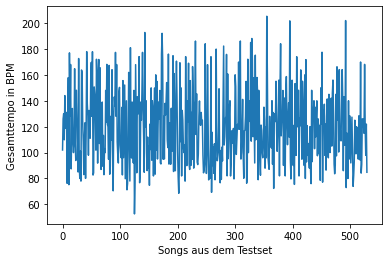

In [45]:
x = list(range(530))
y = test_tempo()
plt.ylabel("Gesamttempo in BPM")
plt.xlabel("Songs aus dem Testset")
plt.plot(x, y) #Wertebreich vom Tempo
plt.show()

In [46]:
def test_oth_features():
    test_oth_features = []
    for num in indices_test:
        test_oth_features.append(other_features(lyrics[num]))
    return(test_oth_features)

In [47]:
pd.DataFrame({'oth_features': test_oth_features()})

,oth_features
0,"[130.6, -235.8, 392, 1.1529, 1647, 1647, 340, ..."
1,"[10.6, 74.4, 37, 1.1935, 146, 146, 31, 31, 24,..."
2,"[348.5, -803.74, 1052, 1.1715, 4725, 4725, 898..."
3,"[224.9, -477.34, 631, 1.0805, 2754, 2754, 584,..."
4,"[134.1, -241.02, 380, 1.0826, 1731, 1731, 351,..."
...,...
525,"[141.3, -262.78, 418, 1.1359, 1800, 1800, 368,..."
526,"[541.3, -1306.14, 1647, 1.1832, 7235, 7235, 13..."
527,"[131.7, -239.73, 402, 1.1754, 1635, 1635, 342,..."
528,"[77.6, -94.25, 224, 1.0874, 1006, 1006, 206, 2..."


In [48]:
#gesamtes Dataset als Vergleich
def oth_features():
    oth_features = []
    for num in list(data.index):
        oth_features.append(other_features(lyrics[num]))
    return(oth_features)

In [49]:
#num_word = 7. Zahl in der Liste
def test_num_words ():
    num_words = []
    for liste in test_oth_features():
        num_words.append(liste[7])
    return(num_words)

In [50]:
#num_chars_total = 5. Zahl in der Liste
def test_num_chars ():
    num_chars = []
    for liste in test_oth_features():
        num_chars.append(liste[5])
    return(num_chars)

In [51]:
#Durchschnitt
sum(test_num_chars())/len(test_num_chars())

2738.4981132075472

In [52]:
#gesamtes Dataset als Vergleich
def num_chars ():
    num_chars = []
    for liste in oth_features():
        num_chars.append(liste[5])
    return(num_chars)

In [53]:
#Durchschnitt des gesamten Datasets
sum(num_chars())/len(num_chars())

2675.676670441676

In [54]:
#gesamtes Dataset als Vergleich
def num_words ():
    num_words = []
    for liste in oth_features():
        num_words.append(liste[7])
    return(num_words)

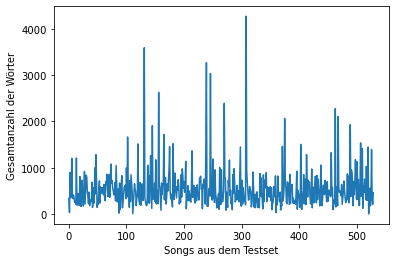

In [55]:
x = list(range(530))
y = test_num_words()
plt.ylabel("Gesamtanzahl der Wörter")
plt.xlabel("Songs aus dem Testset")
plt.plot(x, y) #Wertebreich Wortanzahl
plt.show()

In [56]:
#Durchschnitt
sum(test_num_words())/len(test_num_words())

548.1811320754717

In [57]:
#Durchschnitt gesamtes Dataset
sum(num_words())/len(num_words())

532.3584371460929

In [58]:
#sentiment['compound'] = 12. Zahl in der Liste
def test_sentiment ():
    sentiment = []
    for liste in test_oth_features():
        sentiment.append(liste[12])
    return(sentiment)

In [59]:
#gesamtes Dataset
def sentiment ():
    sentiment = []
    for liste in oth_features():
        sentiment.append(liste[12])
    return(sentiment)

In [60]:
#neg = []
#for elem in test_sentiment():
#    if elem >0: 
#        neg.append(elem)
#    print(len(neg))
#285 (54%)

In [61]:
#gesamtes Dataset
#neg_ = []
#for elem in sentiment():
#    if elem >0: 
#        neg_.append(elem)
#    print(len(neg_))
#917 (52%)

In [62]:
#pos = []
#for elem in test_sentiment():
#    if elem <0: 
#        pos.append(elem)
#        print(len(pos))
#243 (46%)

In [63]:
#neu = []
#for elem in test_sentiment():
#    if elem ==0: 
#        neu.append(elem)
#    print(len(neu))
#2 (0,4%)

In [64]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,10533,10534,10535,10536,10537,10538,10539,10540,10541,10542
610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.2440,1795.0,1795.0,336.0,336.0,77.0,0.091,0.087,0.822,-0.6877
1163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.1189,2823.0,2823.0,572.0,572.0,202.0,0.056,0.044,0.900,-0.8424
1096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0000,804.0,804.0,205.0,205.0,12.0,0.000,0.029,0.971,0.4717
451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.2040,2253.0,2253.0,446.0,446.0,247.0,0.153,0.125,0.722,-0.9691
490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.1494,1627.0,1627.0,328.0,328.0,112.0,0.044,0.082,0.874,0.9122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.1225,2173.0,2173.0,457.0,457.0,111.0,0.059,0.117,0.824,0.9913
1294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.2012,3555.0,3555.0,686.0,686.0,363.0,0.134,0.077,0.789,-0.9945
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.2892,2661.0,2661.0,491.0,491.0,223.0,0.096,0.075,0.829,-0.9163
1459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.1930,1396.0,1396.0,285.0,285.0,87.0,0.021,0.288,0.690,0.9980


## Evaluating the results

In [65]:
report = classification_report( y_test, y_preds )

In [66]:
print(report) #das ist für das Testset

              precision    recall  f1-score   support

           0       0.58      0.55      0.57        95
           1       0.39      0.50      0.44       102
           2       0.87      0.81      0.84       333

    accuracy                           0.70       530
   macro avg       0.61      0.62      0.61       530
weighted avg       0.73      0.70      0.71       530



Pecision = Wie viele der vom System erkannten Beispiele sind tatsächlich „positiv“?,
Recall = Wie viele der positiven Beispiele werden vom System erkannt?,
F1-Score = je höher der F1-Score, desto besser die Harmonik zwischen Precision und Recall,
support = Vorkommen der vorhergesagten Label im Testset

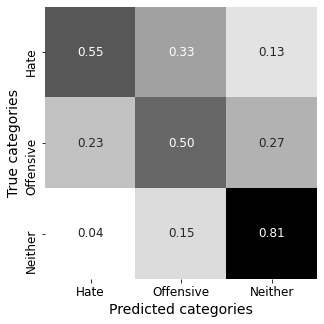

In [67]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

<AxesSubplot:>

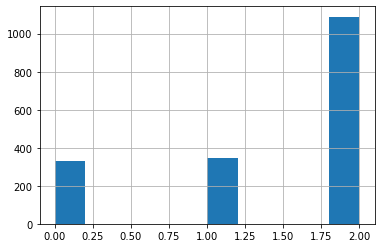

In [75]:
#True distribution
y.hist() #wahre Label, bezieht sich auf das Trainingsset

<AxesSubplot:>

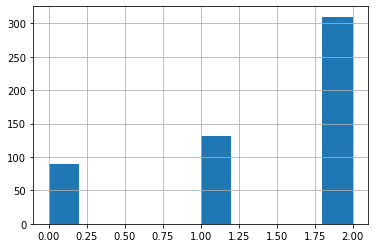

In [71]:
pd.Series(y_preds).hist() #vorhergesagte Label, bezieht sich auf das Testset